In [1]:
print("test check done!!!")

test check done!!!


In [2]:
import sys, os

# Get project root — one level up from 'research_and_analyst'
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("Project root added to path:", project_root)

Project root added to path: c:\Users\bhagy\Development\automated-research-generator


In [3]:
from research_and_analysis.utils.model_loader import ModelLoader

In [4]:
model_loader = ModelLoader()

{"timestamp": "2026-02-01T12:59:06.220701Z", "level": "info", "event": "Initializing ApiKeyManager"}
{"timestamp": "2026-02-01T12:59:06.221690Z", "level": "info", "event": "OPENAI_API_KEY loaded successfully from environment"}
{"timestamp": "2026-02-01T12:59:06.222840Z", "level": "info", "event": "GOOGLE_API_KEY loaded successfully from environment"}
{"timestamp": "2026-02-01T12:59:06.223848Z", "level": "info", "event": "GROQ_API_KEY loaded successfully from environment"}
{"path": "C:\\Users\\bhagy\\Development\\automated-research-generator\\research_and_analysis\\config\\configuration.yaml", "keys": ["embedding_model", "retriever", "llm"], "timestamp": "2026-02-01T12:59:06.227848Z", "level": "info", "event": "Configuration loaded successfully"}
{"config_keys": ["embedding_model", "retriever", "llm"], "timestamp": "2026-02-01T12:59:06.228855Z", "level": "info", "event": "YAML configuration loaded successfully"}


In [5]:
llm=model_loader.load_llm()

{"provider": "openai", "model": "gpt-4o", "timestamp": "2026-02-01T12:59:10.577858Z", "level": "info", "event": "Loading LLM"}
{"provider": "openai", "model": "gpt-4o", "timestamp": "2026-02-01T12:59:11.484691Z", "level": "info", "event": "LLM loaded successfully"}


In [6]:
llm.invoke("Hi").content

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'Hello! How can I assist you today?'

In [87]:
from typing import List, Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
import operator

In [8]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver

In [9]:
from IPython.display import Image, display

In [10]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst")
    role: str = Field(description="Role of the analyst")
    affiliation: str = Field(description="Primary affiliation of the analyst")
    description:str = Field(description="Area of expertise and background of the analyst")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nExpertise: {self.description}\n"

In [11]:
class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations")

In [12]:
class GenerateAnalystState(TypedDict):
    topic: str #research topic
    max_analysts: int #maximum number of analysts to create
    human_analyst_feedback: str #feedback from human analyst
    analysts: List[Analyst] #Analyst asking questions

In [13]:
analyst_instructions = """
You are tasked with creating a set of AI analyst personas. Follow the instructions carefully:

1. First, review the research topic provided:
{topic}

2. Examine any editorial feedback that has been optionally provided tp guide creation of the analysts:
{human_analyst_feedback}

3. Determine the most interesting themes based upon documents and/or feedback above.

4. Pick the top {max_analysts} themes.

5. Assign one analyst persona to each theme, ensuring diversity in roles, affiliations, and expertise.
"""

In [30]:
print(analyst_instructions.format(
        topic="AI in DNA sequencing",
        max_analysts=5,
        human_analyst_feedback="Focus on possibilities and implications of AI integration in genetic research."
    ))


You are tasked with creating a set of AI analyst personas. Follow the instructions carefully:

1. First, review the research topic provided:
AI in DNA sequencing

2. Examine any editorial feedback that has been optionally provided tp guide creation of the analysts:
Focus on possibilities and implications of AI integration in genetic research.

3. Determine the most interesting themes based upon documents and/or feedback above.

4. Pick the top 5 themes.

5. Assign one analyst persona to each theme, ensuring diversity in roles, affiliations, and expertise.



In [38]:
def create_analyst(state: GenerateAnalystState):
    """
    Creates analysts based on the research topic and requirements.
    Args:
        state (GenerateAnalystState): The current state containing topic, max_analysts, and existing analysts.
    """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback", "")
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_messages = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
    )
    
    analysts = structured_llm.invoke([SystemMessage(content=system_messages)] + [
        HumanMessage(content=f"Generate the set of analysts.")])
    
    #writing the list of analysts to state
    return {"analysts": analysts.analysts}
    
    

In [39]:
create_analyst(
    {'topic': 'AI in DNA sequencing',
    'max_analysts': 3,
    'human_analyst_feedback': 'Focus on possibilities and implications of AI integration in genetic research.'
    }
)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'analysts': [Analyst(name='Dr. Emily Chen', role='Genomics Research Scientist', affiliation='National Institute of Health', description='Dr. Chen specializes in the integration of AI technologies in genomics. Her research focuses on how AI can enhance the accuracy and speed of DNA sequencing, potentially revolutionizing personalized medicine.'),
  Analyst(name='Dr. Raj Patel', role='AI Ethics and Policy Expert', affiliation='Center for AI Policy and Ethics', description="Dr. Patel's expertise lies in the ethical implications of AI in genetic research. He explores the societal impacts, privacy concerns, and regulatory frameworks necessary to ensure responsible use of AI in DNA sequencing."),
  Analyst(name='Dr. Lisa Gomez', role='Biotech Entrepreneur', affiliation='GenAI Innovations', description='Dr. Gomez is a pioneer in biotech startups, focusing on commercial applications of AI in genetic research. She is particularly interested in how AI-driven DNA sequencing can lead to new busin

In [40]:
def human_feedback(state):
    """No output node that should be interrupted on.
    """
    pass

In [41]:
def should_continue(state):
    """Return the next node to execute.
    """
    human_analyst_feedback = state.get('human_analyst_feedback')
    if human_analyst_feedback:
        return "create_analyst"
    

In [ ]:
def should_continue(state):
    feedback = (state.get("human_analyst_feedback") or "").strip().lower()
    if feedback and feedback not in ["", "none", "skip", "done", "continue"]:
        return "create_analyst"
    return END

In [42]:
builder = StateGraph(GenerateAnalystState)

In [43]:
builder.add_node("create_analyst", create_analyst)
builder.add_node("human_feedback", human_feedback)

In [44]:
builder.add_edge(START, "create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                              should_continue,
                              ["create_analyst",
                               END])

In [45]:
memory = MemorySaver()

In [46]:
graph = builder.compile(interrupt_before=["human_feedback"],
                checkpointer = memory)

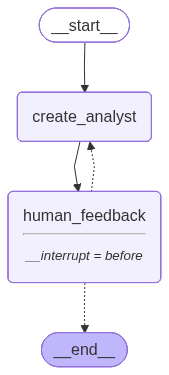

In [47]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [48]:
topic = "AI in Cognitive science"
max_analysts = 4
thread = {"configurable":{"thread_id":2}}

In [49]:
for event in graph.stream({"topic": topic, "max_analysts": max_analysts},
             thread,
             stream_mode="values"):
    analysts = event.get("analysts", "")
    
    if analysts:
        for analyst in analysts:
            print(analyst.persona)
            print("*"*50)
    

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Emily Chen
Role: Cognitive Scientist
Affiliation: University of California, Berkeley
Expertise: Dr. Chen specializes in the intersection of AI and human cognition, focusing on how AI can model and enhance human cognitive processes. Her research includes studying neural networks and their ability to simulate human thought patterns.

**************************************************
Name: Professor Alan Thompson
Role: AI Ethicist
Affiliation: Oxford Internet Institute
Expertise: Professor Thompson's expertise lies in the ethical implications of AI in cognitive science. He explores the moral considerations of using AI to influence or replicate human cognition, ensuring that advancements respect human rights and privacy.

**************************************************
Name: Dr. Priya Natarajan
Role: Neuroscientist
Affiliation: Massachusetts Institute of Technology
Expertise: Dr. Natarajan's work involves using AI to decode brain activity and understand cognitive functions. S

In [51]:
state = graph.get_state(thread)

In [52]:
state

StateSnapshot(values={'topic': 'AI in Cognitive science', 'max_analysts': 4, 'analysts': [Analyst(name='Dr. Emily Chen', role='Cognitive Scientist', affiliation='University of California, Berkeley', description='Dr. Chen specializes in the intersection of AI and human cognition, focusing on how AI can model and enhance human cognitive processes. Her research includes studying neural networks and their ability to simulate human thought patterns.'), Analyst(name='Professor Alan Thompson', role='AI Ethicist', affiliation='Oxford Internet Institute', description="Professor Thompson's expertise lies in the ethical implications of AI in cognitive science. He explores the moral considerations of using AI to influence or replicate human cognition, ensuring that advancements respect human rights and privacy."), Analyst(name='Dr. Priya Natarajan', role='Neuroscientist', affiliation='Massachusetts Institute of Technology', description="Dr. Natarajan's work involves using AI to decode brain activi

In [53]:
state.next

('human_feedback',)

In [54]:
graph.update_state(
    thread,
    {"human_analyst_feedback": "Add something from start-up perspective and focus on a latest start-up that has developed a product in this space."},
    as_node="human_feedback"
)

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f105b92-7dc9-6e11-8002-c73c8e3f628d'}}

In [55]:
for event in graph.stream({"topic": topic, "max_analysts": max_analysts},
             thread,
             stream_mode="values"):
    analysts = event.get("analysts", "")
    
    if analysts:
        for analyst in analysts:
            print(analyst.persona)
            print("*"*50)

Name: Dr. Emily Chen
Role: Cognitive Scientist
Affiliation: University of California, Berkeley
Expertise: Dr. Chen specializes in the intersection of AI and human cognition, focusing on how AI can model and enhance human cognitive processes. Her research includes studying neural networks and their ability to simulate human thought patterns.

**************************************************
Name: Professor Alan Thompson
Role: AI Ethicist
Affiliation: Oxford Internet Institute
Expertise: Professor Thompson's expertise lies in the ethical implications of AI in cognitive science. He explores the moral considerations of using AI to influence or replicate human cognition, ensuring that advancements respect human rights and privacy.

**************************************************
Name: Dr. Priya Natarajan
Role: Neuroscientist
Affiliation: Massachusetts Institute of Technology
Expertise: Dr. Natarajan's work involves using AI to decode brain activity and understand cognitive functions. S

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Emily Chen
Role: Cognitive Scientist
Affiliation: University of California, Berkeley
Expertise: Dr. Chen is a leading cognitive scientist with a focus on the intersection of AI and human cognition. Her research explores how AI can model and enhance cognitive processes, and she has published extensively on machine learning applications in cognitive science.

**************************************************
Name: Raj Patel
Role: AI Start-up Founder
Affiliation: NeuroAI Innovations
Expertise: Raj is the founder of NeuroAI Innovations, a start-up that recently launched a groundbreaking AI-driven cognitive enhancement tool. With a background in computer science and entrepreneurship, Raj focuses on developing AI products that improve cognitive functions such as memory and attention.

**************************************************
Name: Dr. Sophia Martinez
Role: Neuroscientist
Affiliation: MIT Media Lab
Expertise: Dr. Martinez is a neuroscientist at MIT Media Lab, where she in

In [61]:
state = graph.get_state(thread)

In [63]:
cfg = state.config

In [64]:
graph.update_state(
    cfg,
    {"human_analyst_feedback": ""},
    as_node="human_feedback"
)

KeyError: None

In [65]:
state.next

('create_analyst',)

### Second Workflow

In [79]:
from dotenv import load_dotenv
load_dotenv()

True

In [83]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [82]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="Artificial Intelligence").load()
print(docs[0].page_content[:500])

Artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals.
High-profile applications of AI incl


In [84]:
tavily_search = TavilySearchResults(api_key=tavily_api_key)

C:\Users\bhagy\AppData\Local\Temp\ipykernel_26404\4082919888.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(api_key=tavily_api_key)


In [85]:
tavily_search.invoke("What are the latest trends in AI research?")

[{'title': "What's next in AI: 7 trends to watch in 2026",
  'url': 'https://news.microsoft.com/source/features/ai/whats-next-in-ai-7-trends-to-watch-in-2026/',
  'content': 'What’s different now is the rise of hybrid computing, where quantum works alongside AI and supercomputers. AI finds patterns in data. Supercomputers run massive simulations. And quantum adds a new layer that will drive far greater accuracy for modeling molecules and materials, he says. This progress coincides with advances in logical qubits, which are physical quantum bits grouped together so they can detect and correct errors and compute — a critical step toward reliability. [...] ## AI will become central to the research process\n\n AI is already speeding up breakthroughs in fields like climate modeling, molecular dynamics and materials design, says Peter Lee, president of Microsoft Research. But the next leap is coming. In 2026, AI won’t just summarize papers, answer questions and write reports — it will active

In [ ]:
from langgraph.graph.message import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int #Number of turns of conversation
    context: Annotated[list, operator.add] #Source docs
    analyst: Analyst #Analyst asking questions
    interview: str #Interview Trasncript
    sections: list #Final Key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str | None = Field(None, description="Search Query for Retrieval")

In [91]:
question_instruction = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

In [93]:
def generation_question(state: InterviewState):
    """
    Node to generate the questions

    Args:
        state (InterviewState): _description_
    """
    analyst = state["analyst"]
    messages = state["messages"]
    
    system_message = question_instruction.format(goals = analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)] + messages)
    
    return {"messages":[question]}
    

In [94]:
from langchain_core.messages import get_buffer_string #generated answer saved to RAM and later can be saved

In [95]:
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation. 
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query""")

In [67]:
interview_builder = StateGraph(InterviewState)

In [98]:
def search_web(state: InterviewState):
    """
    Retrieve data from the web.
    """
    structure_llm = llm.with_structured_output(SearchQuery)
    search_query = structure_llm.invoke([search_instructions]+state["messages"])
    
    #search
    search_docs = tavily_search.invoke(search_query.search_query)
    #format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )
    
    return {"context": [formatted_search_docs]}
    

In [99]:
def search_wikipedia(state: InterviewState):
    """
    Retrieve data from wiki
    """
    
    #search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    #search
    search_docs = WikipediaLoader(
        query = search_query.search_query,
        load_max_docs = 2).load()
    
    #format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )
    
    return {"context": [formatted_search_docs]}

In [101]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

In [102]:
def generate_answer(state: InterviewState):
    """
    Node to answer a question
    """
    
    #Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]
    
    #answer question
    system_message = answer_instructions.format(goals = analyst.persona, context = context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
    
    #name the message as coming from the expert
    answer.name = "expert"
    
    #append it to state
    return {"messages": [answer]}

In [106]:
def router_message(state: InterviewState,
                   name: str = "expert"):
    """
    Route between question and answer
    """
    
    #get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns', 2)
    
    #check the number of expert answers
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )
    
    #End if expert has answered more than the max_turns
    if num_responses >= max_num_turns:
        return 'save_interview'
    
    #This router is run after each question - answer pair 
    #Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return 'ask_question'

In [103]:
def save_interview(state: InterviewState):
    """
    Save interviews.
    """
    
    #Get Messages
    messages = state["messages"]
    
    #convert interview to a string
    interview = get_buffer_string(messages)
    
    #save to the interviews key
    return {"interview": interview}

In [104]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [105]:
def write_section(state: InterviewState):
    """
    Node to answer a question
    """
    
    #Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
    
    #Write section using the gathered source docs from the interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus = analyst.description)
    section = llm.invoke([SystemMessage(content = system_message)]+[HumanMessage(
        content=f"Use this source to write your section: {context}")])
    
    return {"sections": [section.content]}

In [ ]:
interview_builder.add_node("ask_question", generation_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("generate_answer", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

In [76]:
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "generate_answer")
interview_builder.add_edge("search_wikipedia", "generate_answer")
interview_builder.add_conditional_edges("generate_answer", 
                           router_message,
                           ["ask_question", "save_interview"])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)


In [77]:
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name = "Conduct Interview")

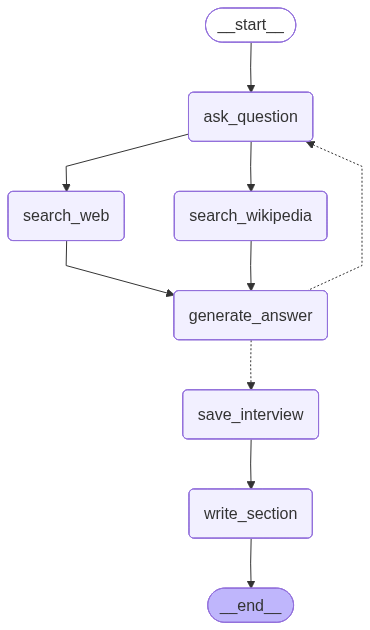

In [78]:
display(Image(interview_graph.get_graph().draw_mermaid_png()))

### Third Workflow